In [1]:
import sys
sys.path.append('../src/')

In [2]:
# Third-party libraries:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# My libraries:
import dataset.dataset as dtset
from dbclass import dbclass_utils as db_utils


In [3]:
# import some data to play with
ds = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
ds['data'] = db_utils.get_pca_data(ds['data'], n_components=80)
# Splitting the data for trainning and for test:
ds_train, ds_validation = dtset.split_data(ds, prop_train=0.5)
ds_validation, ds_test = dtset.split_data(ds_validation, prop_train=0.5)
ds_train = dtset.join_data((ds_train, ds_validation))

In [4]:
# Train a SVM classification model
# Fitting the classifier to the training set:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                    param_grid, cv=5, n_jobs=4)
clf = clf.fit(ds_train['data'], ds_train['target'])
print("\nBest estimator found by grid search:")
print(clf.best_estimator_)


Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01)


                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.70      0.82        20
     Colin Powell       0.79      0.90      0.84        59
  Donald Rumsfeld       0.85      0.74      0.79        31
    George W Bush       0.41      0.97      0.58       133
Gerhard Schroeder       0.95      0.75      0.84        28
      Hugo Chavez       1.00      0.72      0.84        18
       Tony Blair       0.84      0.72      0.78        36
          Unknown       0.00      0.00      0.00       162

         accuracy                           0.57       487
        macro avg       0.73      0.69      0.69       487
     weighted avg       0.46      0.57      0.48       487


Confusion matrix:


C:\Users\weldl\Miniconda3\envs\dbclass\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\weldl\Miniconda3\envs\dbclass\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\weldl\Miniconda3\envs\dbclass\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


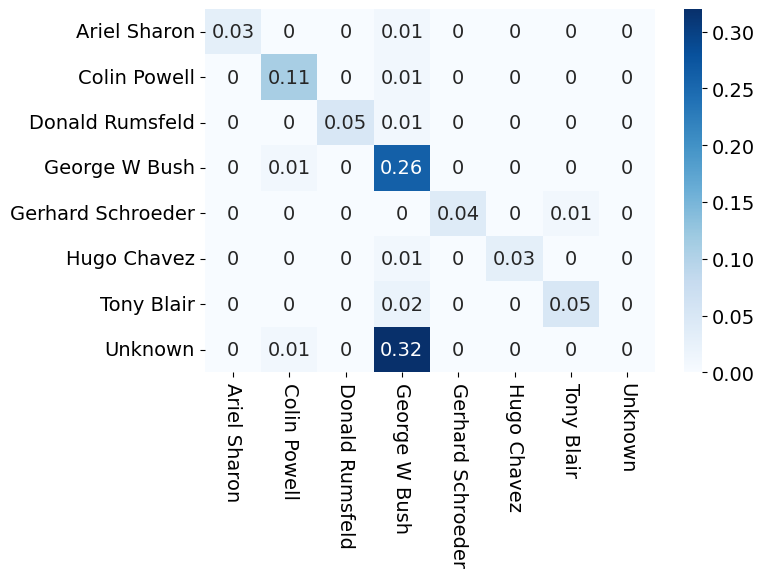

accuracy 0.581633


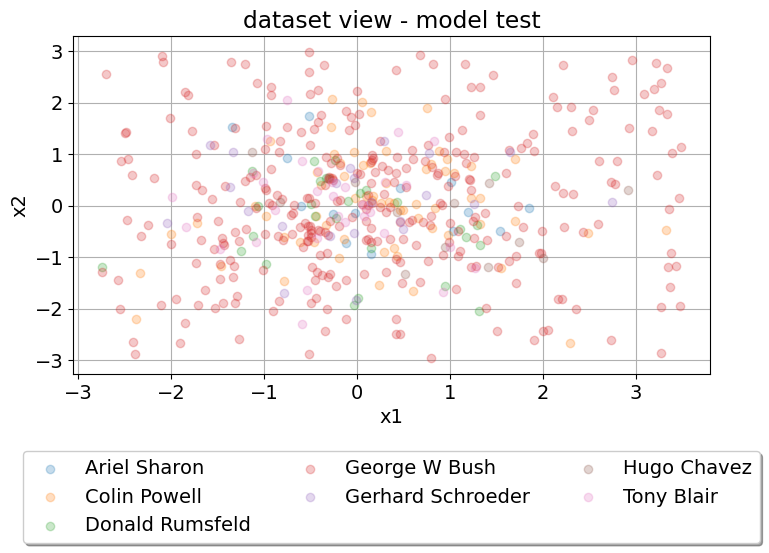

In [5]:
# Quantitative evaluation of the model quality on the test set:
ds_test = dtset.insert_rand_noclass(ds_test)
y_pred = clf.predict(ds_test['data'])
ds_pred = db_utils.print_classification_report(ds_test, y_pred)
confusion_matrix = db_utils.build_confusion_matrix(ds_test['target'], y_pred)

print('\nConfusion matrix:')
cmap = 'Blues'
noclass_label = "Unknown"
vmin = min([0, confusion_matrix.min()])
vmax = max([confusion_matrix.max()])    
plt.figure()
sns.heatmap(confusion_matrix, annot=np.round(confusion_matrix, 2), cmap=cmap, vmin=vmin, vmax=vmax)
target_names = [str(x) for x in ds_test['target_names']] + [noclass_label]
target_idxs = [i+0.5 for i in range(len(target_names))]
plt.xticks(target_idxs, target_names, rotation=-90)
plt.yticks(target_idxs, target_names, rotation=0)
plt.tight_layout()
plt.show()

class_metrics = db_utils.get_class_metrics(confusion_matrix)
for metric in class_metrics.keys():
    print(metric, class_metrics[metric])
dtset.plot_dataset(ds_pred, feat_index=(0, 1), labeled=True, fig_name="model test")